In [1]:
from typing import List
import pylibjpeg

In [2]:
import gc
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, KFold
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

import wandb

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT

TRAIN_IMAGES_PATH = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_images'
TEST_IMAGES_PATH = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/test_images'
METADATA_PATH = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/metadata'
EFFNET_CHECKPOINTS_PATH = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/checkpts'

EFFNET_MAX_TRAIN_BATCHES = 10000
EFFNET_MAX_EVAL_BATCHES = 1000
ONE_CYCLE_MAX_LR = 0.0004
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 500
N_MODELS_FOR_INFERENCE = 2

os.environ['WANDB_API_KEY'] = '44e8b9bf7e182327bfb2003ed06792ea184aac37'
# 44e8b9bf7e182327bfb2003ed06792ea184aac37

print(torch.cuda.is_available())

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
# if DEVICE == 'cuda':
#     BATCH_SIZE = 32
# else:
#     BATCH_SIZE = 2
BATCH_SIZE = 32

N_FOLDS = 5

False


Text(0.5, 1.0, 'jpeg')

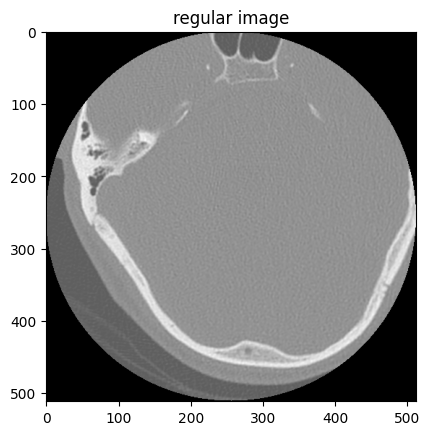

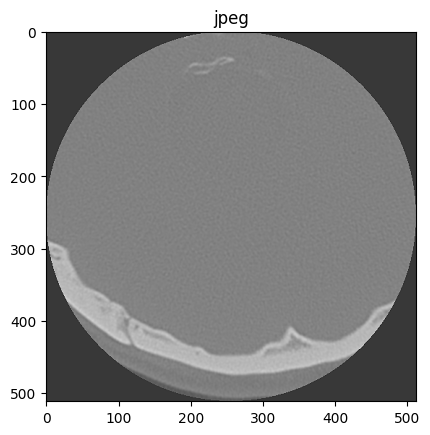

In [4]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('regular image')

im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10014/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('jpeg')

In [5]:
import pandas as pd
df_seg = pd.read_csv(f'{METADATA_PATH}/meta_segmentation.csv')

split = GroupKFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg, groups=df_seg.StudyInstanceUID)):
    df_seg.loc[test_idx, 'split'] = k

split = KFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg)):
    df_seg.loc[test_idx, 'random_split'] = k

slice_max_seg = df_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
df_seg['SliceRatio'] = 0
df_seg['SliceRatio'] = df_seg['Slice'] / df_seg['StudyInstanceUID'].map(slice_max_seg)

df_seg.sample(10)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,split,random_split,SliceRatio
7277,1.2.826.0.1.3680043.18935,99,512,512,0.625,-60.400000,-39.600000,-74.250000,1,1,0,0,0,0,0,3.0,1.0,0.304615
27592,1.2.826.0.1.3680043.6078,174,512,512,0.625,-85.500000,-54.400000,-115.735000,0,0,0,0,1,1,1,1.0,4.0,0.690476
7034,1.2.826.0.1.3680043.18906,207,512,512,1.000,-72.362300,-282.362300,-274.300000,0,0,0,1,1,0,0,3.0,1.0,0.589744
9581,1.2.826.0.1.3680043.20647,240,512,512,0.625,-65.000000,-17.299000,-194.156000,0,0,0,0,0,0,0,4.0,1.0,0.912548
24733,1.2.826.0.1.3680043.3992,105,512,512,0.625,-110.900000,-85.000000,-139.500000,0,1,1,0,0,0,0,1.0,4.0,0.416667
25295,1.2.826.0.1.3680043.4769,142,512,512,1.000,-116.077000,-32.952880,-581.300000,0,0,0,1,1,0,0,1.0,4.0,0.539924
2762,1.2.826.0.1.3680043.14267,438,512,512,0.600,-109.822266,-269.322266,223.700000,0,0,0,0,0,0,0,1.0,0.0,0.926004
23363,1.2.826.0.1.3680043.32590,232,512,512,0.625,-85.000000,-15.900000,-123.625000,0,0,0,0,0,0,1,2.0,3.0,0.862454
21783,1.2.826.0.1.3680043.32071,75,512,512,0.625,-73.133000,-18.341000,-124.555000,1,1,0,0,0,0,0,3.0,3.0,0.285171
10844,1.2.826.0.1.3680043.21651,319,512,512,1.000,-113.600000,-222.400009,-967.010071,0,0,0,0,1,1,0,0.0,1.0,0.625490


In [6]:
class VertebraeSegmentDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')
        try:
            img = load_dicom(path)[0]
            img = np.transpose(img, (2, 0, 1))  # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1' in self.df.columns:
            vert_targets = torch.as_tensor(self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            return img, vert_targets
        return img

    def __len__(self):
        return len(self.df)


ds_seg = VertebraeSegmentDataSet(df_seg, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y = ds_seg[300]
X.shape, y.shape

(torch.Size([3, 384, 384]), torch.Size([7]))

In [7]:
class SegEffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
    
    def forward(self, x):
        x = self.model(x)['flatten']
        return self.nn_vertebrae(x)
    
    def predict(self, x):
        pred = self.forward(x)
        return torch.sigmoid(pred)
    
# path of model downloaded /Users/jarvis/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
model = SegEffnetModel()
model.predict(torch.randn(1, 3, 512, 512))
        

tensor([[0.4980, 0.4710, 0.5224, 0.4782, 0.4919, 0.5161, 0.4947]],
       grad_fn=<SigmoidBackward0>)

In [8]:
del model

In [9]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [10]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [11]:
def save_model(name, model, optim, scheduler):
    torch.save({
        'model': model.state_dict(),
        'optim': optim.state_dict(),
        'scheduler': scheduler
    }, f'{name}.tph')

def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data['model'])
    optim = torch.optim.Adam(model.parameters())
    optim.load_state_dict(data['optim'])
    return model, optim, data['scheduler']

# quick test
model = torch.nn.Linear(2, 1)
optim = torch.optim.Adam(model.parameters())
save_model('testmodel', model, optim, None)

model1, optim1, scheduler1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
assert torch.all(next(iter(model1.parameters())) == next(iter(model.parameters()))).item(), "Loading/saving is inconsistent!"

In [12]:
def evaluate_segeffnet(model: SegEffnetModel, ds, max_batches=1e9, shuffle=False):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    # dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=os.cpu_count(), collate_fn=filter_nones)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, collate_fn=filter_nones)

    with torch.no_grad():
        model.eval()
        pred = []
        y = []
        progress = tqdm(dl_test, desc='Eval', miniters=100)
        for i, (X, y_vert) in enumerate(progress):
            # with autocast():
            y_vert_pred = model.predict(X.to(DEVICE))
            pred.append(y_vert_pred.cpu().numpy())
            y.append(y_vert.numpy())
            acc = np.mean(np.mean((pred[-1] > 0.5) == y[-1], axis=0))
            progress.set_description(f'Eval acc: {acc: .02f}')
            if i >= max_batches:
                break
        pred = np.concatenate(pred)
        y = np.concatenate(y)
        acc = np.mean(np.mean((pred > 0.5) == y, axis=0))
        return acc, pred

In [13]:

import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = 'c1-c7_extraction_ai.ipynb'
wandb.login()

wandb: Currently logged in as: hawkeye05 (team-fyp). Use `wandb login --relogin` to force relogin


True

In [14]:
%%wandb


def train_segeffnet(ds_train, ds_eval, logger, name):
    torch.manual_seed(42)
    # dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), collate_fn=filter_nones)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=filter_nones)

    model = SegEffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=1, steps_per_epoch=min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train)), pct_start=ONE_CYCLE_PCT_START)
    model.train()
    scaler = GradScaler()

    progress = tqdm(dl_train, desc='Train', miniters=10)
    for batch_idx, (X,  y_vert) in enumerate(progress):

        if batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
            eval_loss = evaluate_segeffnet(model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[0]
            model.train()
            if logger is not None:
                logger.log({'eval_acc': eval_loss})
            if batch_idx > 0:  # don't save untrained model
                save_model(name, model, optim, scheduler)

        if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
            break

        optim.zero_grad()
        with autocast():
            y_vert_pred = model.forward(X.to(DEVICE))
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE))

            if np.isinf(loss.item()) or np.isnan(loss.item()):
                print(f'Bad loss, skipping the batch {batch_idx}')
                del y_vert_pred, loss
                gc_collect()
                continue

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        scheduler.step()

        progress.set_description(f'Train loss: {loss.item():.02f}')
        if logger is not None:
            logger.log({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})


    eval_loss = evaluate_segeffnet(model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[0]
    if logger is not None:
        logger.log({'eval_acc': eval_loss})

    save_model(name, model, optim, scheduler)
    return model


seg_models = []
for fold in range(N_FOLDS):
    fname = os.path.join(f'{EFFNET_CHECKPOINTS_PATH}/segeffnetv2-f{fold}.tph')
    if os.path.exists(fname):
        print(f'Found cached model {fname}')
        seg_models.append(load_model(SegEffnetModel(), f'segeffnetv2-f{fold}', EFFNET_CHECKPOINTS_PATH)[0].to(DEVICE))
    else:
        with wandb.init(project='CERVICAL_DETECTION', name=f'SegEffNet-v2-fold{fold}') as run:
            gc_collect()
            ds_train = VertebraeSegmentDataSet(df_seg.query('split != @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            ds_eval = VertebraeSegmentDataSet(df_seg.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            train_segeffnet(ds_train, ds_eval, run, f'segeffnetv2-f{fold}')

Found cached model /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/checkpts/segeffnetv2-f0.tph
Found cached model /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/checkpts/segeffnetv2-f1.tph
Found cached model /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/checkpts/segeffnetv2-f2.tph
Found cached model /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/checkpts/segeffnetv2-f3.tph
Found cached model /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/checkpts/segeffnetv2-f4.tph


In [15]:
WEIGHTS.transforms()

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
def predict_vertebrae(df, seg_models: List[SegEffnetModel]):
    df = df.copy()
    ds = VertebraeSegmentDataSet(df, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
    # dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), collate_fn=filter_nones)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=filter_nones)

    predictions = []
    with torch.no_grad():
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, X in enumerate(progress):
                with autocast():
                    pred = torch.zeros(len(X), 7).to(DEVICE)
                    for model in seg_models:
                        pred += model.predict(X.to(DEVICE)) / len(seg_models)
                        # print(model.predict(X.to(DEVICE)))
                    predictions.append(pred)
    predictions = torch.concat(predictions).cpu().numpy()
    return predictions

In [17]:
df_train = pd.read_csv(os.path.join(METADATA_PATH, 'meta_train_clean.csv'))

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

Eval:   0%|          | 0/18 [00:00<?, ?it/s]

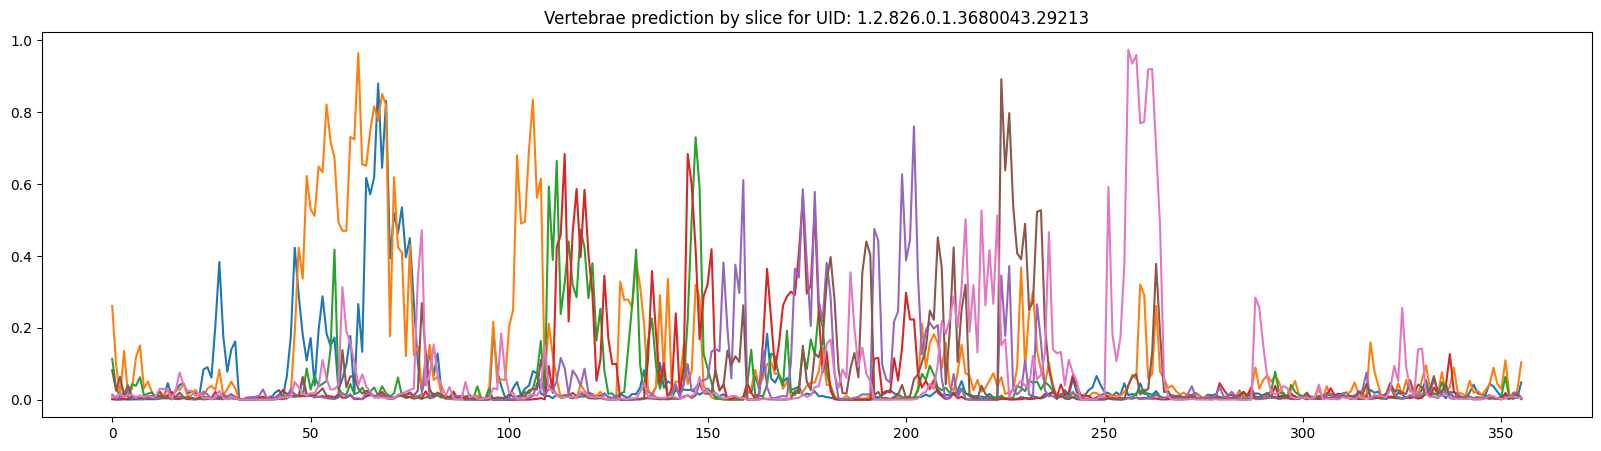

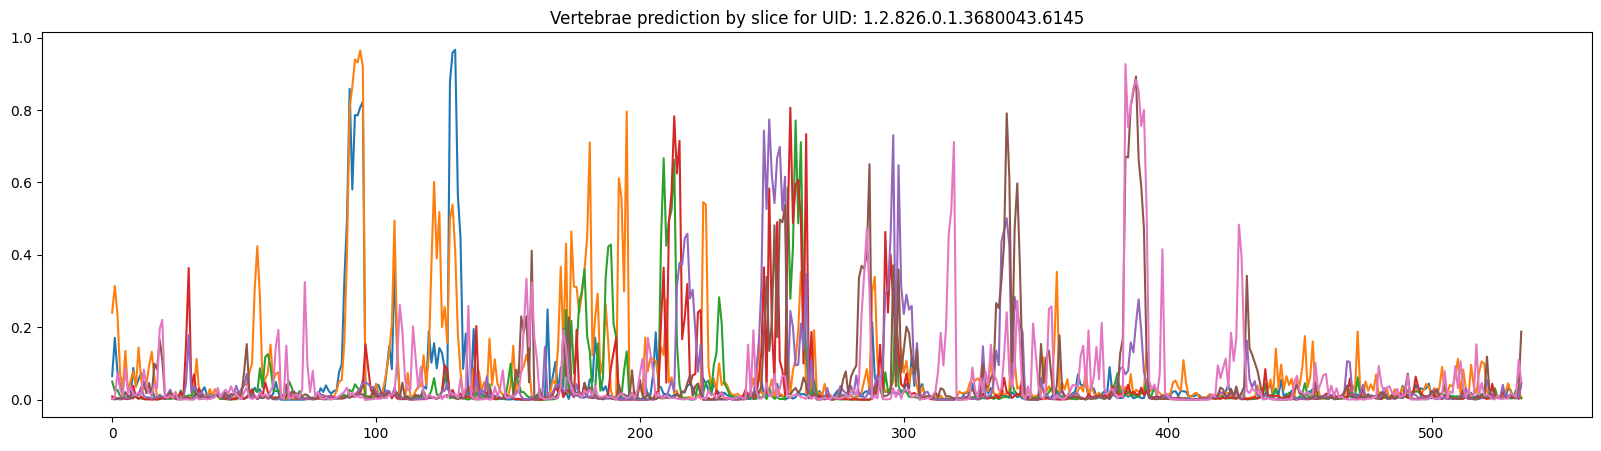

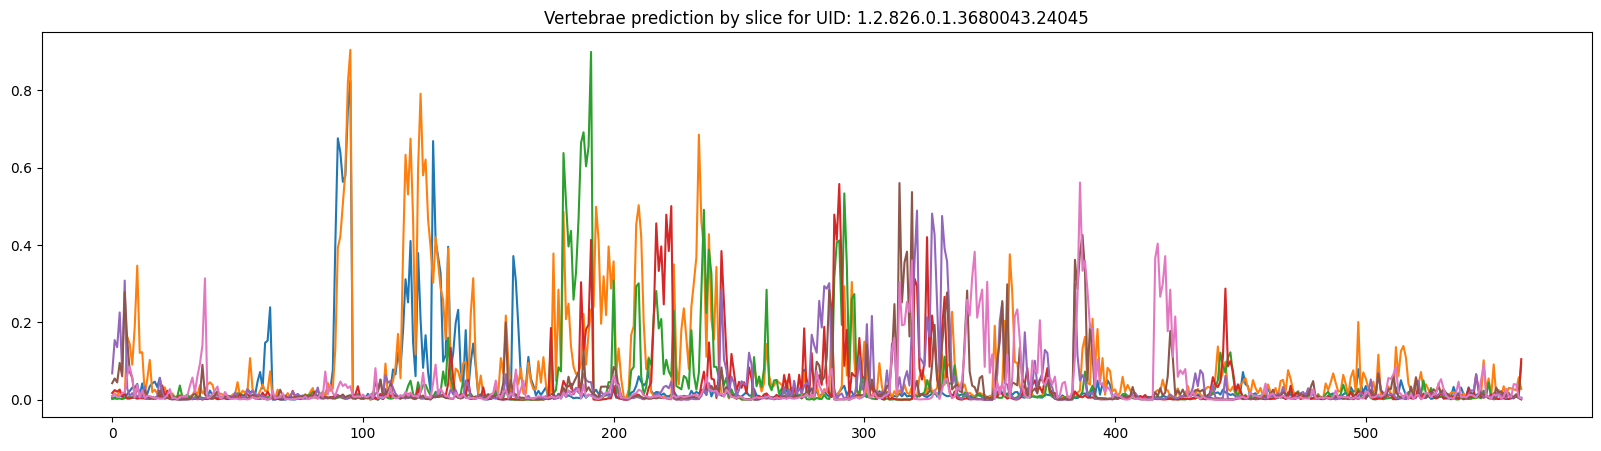

In [18]:
for uid in np.random.choice(df_train.StudyInstanceUID, 3):
    pred = predict_vertebrae(df_train.query('StudyInstanceUID == @uid'), seg_models[:2])
    plt.figure(figsize=(20, 5))
    plt.plot(pred)
    plt.title(f'Vertebrae prediction by slice for UID: {uid}')

In [21]:
pred = predict_vertebrae(df_train, seg_models[:N_MODELS_FOR_INFERENCE])

Eval:   0%|          | 0/22238 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
# df_train[[f'C{i}' for i in range(1, 8)]] = pred
# df_train.to_csv('ai_train_segmented.csv', index=False)

# you can find checkpoints along with the output dataset in https://www.kaggle.com/datasets/vslaykovsky/vertebrae-detection-checkpoints